In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_probability as tfp 
import seaborn as sns 
import geopandas 
import datetime
import scipy as sp

In [2]:
sns.set_theme()

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

In [4]:
hpai_main = pd.read_csv('data_files/combinedDataset20221130 _1_.csv')
hpai_wild = pd.read_csv('data_files/wildBirdData20221130 _1_.csv')
hpai_poultry = pd.read_excel('data_files/GBPR Poultry Premises Extract 01Dec22 _1_.xlsx')

## Preview the data

In [5]:
hpai_main.head(5)

,dprNumber,aivNumber,reportDate,Status,NDI1Type,Resolution,Stock Details,CPH,Country,dprID,...,PZ/SZ presence,Lat,Long,Genomics,cullStart,cullEnd,dispComplete,cdEffective,County,premisesType
0,DPR 2022/389,NaN,28/11/2022,Pending,Report case- Clinical,NaN,"80,000",38/270/6002,England,2022 389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suffolk,Ducks
1,DPR 2022/388,NaN,28/11/2022,Pending,Report case- Clinical,NaN,3342,06/369/0014,England,2022 388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cheshire West and Chester,Turkeys
2,DPR 2022/387,NaN,26/11/2022,Pending,Samples taken for laboratory testing,NaN,"Approx 400 chickens, 78\r\r\ngeese, 18 turkeys...",28/461/0002,England,2022 387,...,NaN,NaN,NaN,NaN,30/11/2022,30/11/2022,NaN,01/12/2022,Norfolk,Chickens
3,DPR 2022/386,AIV 2022/218,26/11/2022,Confirmed,Interim Results - POSITIVE,Confirmed on Lab,32000,70/224/0125,Scotland,2022 386,...,NaN,57.568064,-2.493343,NaN,29/11/2022,NaN,NaN,NaN,Aberdeenshire,Chickens
4,DPR 2022/385,NaN,25/11/2022,Not Confirmed,Final Report,Negated on Clinical,4,NaN,Wales,2022 385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caerphilly,Chickens


In [6]:
hpai_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dprNumber       504 non-null    object 
 1   aivNumber       324 non-null    object 
 2   reportDate      540 non-null    object 
 3   Status          504 non-null    object 
 4   NDI1Type        504 non-null    object 
 5   Resolution      495 non-null    object 
 6   Stock Details   499 non-null    object 
 7   CPH             369 non-null    object 
 8   Country         503 non-null    object 
 9   dprID           504 non-null    object 
 10  aivID           324 non-null    object 
 11  ipNumber        134 non-null    float64
 12  region          191 non-null    object 
 13  approxNumBirds  190 non-null    object 
 14  Year            324 non-null    float64
 15  Season          324 non-null    float64
 16  Subtype         249 non-null    object 
 17  infDate         320 non-null    obj

Comments: 
- unique ID for each farm
- dates (resolution is daily) 
    - format is DD/MM/YYYY
    - reported date for initial infection? 
    - culling dates for end of infectious period (can be longer than 1 day - should factor into the model, decay term? ) 
    - clarify: infDate, confDate, reportDate
- herd details (types of birds present - cat var in model to tell difference in susceptibility) 
- herd size
- spatial component (have geolocation and regional area - can impute from geolocation if need be)

In [7]:
hpai_poultry.head()

,Location Id,AHO,Created Datetime,Updated Datetime,Easting,Northing,OS Map Reference
0,L1000007,APHA Leicester,2008-07-15,2013-08-22 09:58:00,458300.0,263000.0,SP5830063000
1,L1000018,APHA Worcester,2008-07-18,2019-01-24 01:16:00,427801.0,282900.0,SP2780182900
2,L1000019,APHA Leicester,2008-07-18,2019-01-02 02:40:00,487900.0,269200.0,SP8790069200
3,L1000036,APHA Worcester,2008-07-24,2011-05-20 03:23:00,423200.0,292900.0,SP2320092900
4,L1000080,APHA Worcester,2008-08-06,2019-01-25 04:12:00,407851.0,301448.0,SK0785101448


In [8]:
hpai_poultry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58119 entries, 0 to 58118
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Location Id       58119 non-null  object        
 1   AHO               57743 non-null  object        
 2   Created Datetime  58119 non-null  datetime64[ns]
 3   Updated Datetime  58119 non-null  datetime64[ns]
 4   Easting           58118 non-null  float64       
 5   Northing          58118 non-null  float64       
 6   OS Map Reference  58118 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 3.1+ MB


Comments: 

- spatial data for farms 
- long/lat coordinates for mapping

In [9]:
hpai_wild.head()

,Bird ID,Lab ID,Species Name,Final Result,Virus Isolated,Date Received,COUNTY,COUNTRY,speciesName,birdFamily,...,Date PHE informed,High Path,Postcode,Comment,date,easting,northing,latitude,longitude,osGridRef
0,AVA-21-050799,AV001973-21,TUFTED_DUCK,Negative,NaN,2021-10-05T00:00:00Z,GREATER LONDON,ENGLAND,TUFTED_DUCK,ducks/geese/swans,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AVA-21-050998,AV001979-21,BLACK-HEADED_GULL,Negative,NaN,2021-10-06T00:00:00Z,TYNE & WEAR,ENGLAND,BLACK-HEADED_GULL,gulls/terns,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AVA-21-051051,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AVA-21-051052,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AVA-21-051053,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
hpai_wild.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Bird ID                5273 non-null   object 
 1   Lab ID                 7247 non-null   object 
 2   Species Name           5273 non-null   object 
 3   Final Result           5273 non-null   object 
 4   Virus Isolated         4650 non-null   object 
 5   Date Received          5273 non-null   object 
 6   COUNTY                 4306 non-null   object 
 7   COUNTRY                4306 non-null   object 
 8   speciesName            7356 non-null   object 
 9   birdFamily             7341 non-null   object 
 10  Order                  7341 non-null   object 
 11  originalReportedOSRef  4941 non-null   object 
 12  originalOSEasting      4718 non-null   float64
 13  originalOSNorthing     4719 non-null   float64
 14  Case Ref Number        2934 non-null   object 
 15  Inde

In [11]:
hpai_wild[['Date Received']].dropna()

,Date Received
0,2021-10-05T00:00:00Z
1,2021-10-06T00:00:00Z
2,2021-10-07T00:00:00Z
3,2021-10-07T00:00:00Z
4,2021-10-07T00:00:00Z
...,...
5268,2022-11-28T00:00:00Z
5269,2022-11-28T00:00:00Z
5270,2022-11-28T00:00:00Z
5271,2022-11-25T00:00:00Z


Comments: 

- dead wild bird reports w/ accompanying HPAI test result 
- long/lat location of carcass 
- species of wild bird (are some species more likely to be the cause?)

# EDA and Data Cleaning

## Time filtering

In [12]:
# Time variables for hpai_main:
# reportDate
# infDate
# confDate
# cullStart
# cullEnd

hpai_main_dates = hpai_main[['reportDate', 'infDate',
                                                                                      'confDate', 'cullStart', 'cullEnd']].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'), axis=1)
hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']].tail()

,reportDate,infDate,confDate,cullStart,cullEnd
535,2021-01-26,2021-01-18,2021-01-27,NaT,NaT
536,2021-02-05,2021-01-30,2021-02-06,NaT,NaT
537,2021-02-10,2020-02-03,2021-02-11,NaT,NaT
538,2021-03-26,2021-03-18,2021-03-27,NaT,NaT
539,2021-03-30,2021-03-21,2021-04-01,NaT,NaT


In [13]:
hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']] = hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

<AxesSubplot:xlabel='reportDate', ylabel='Count'>

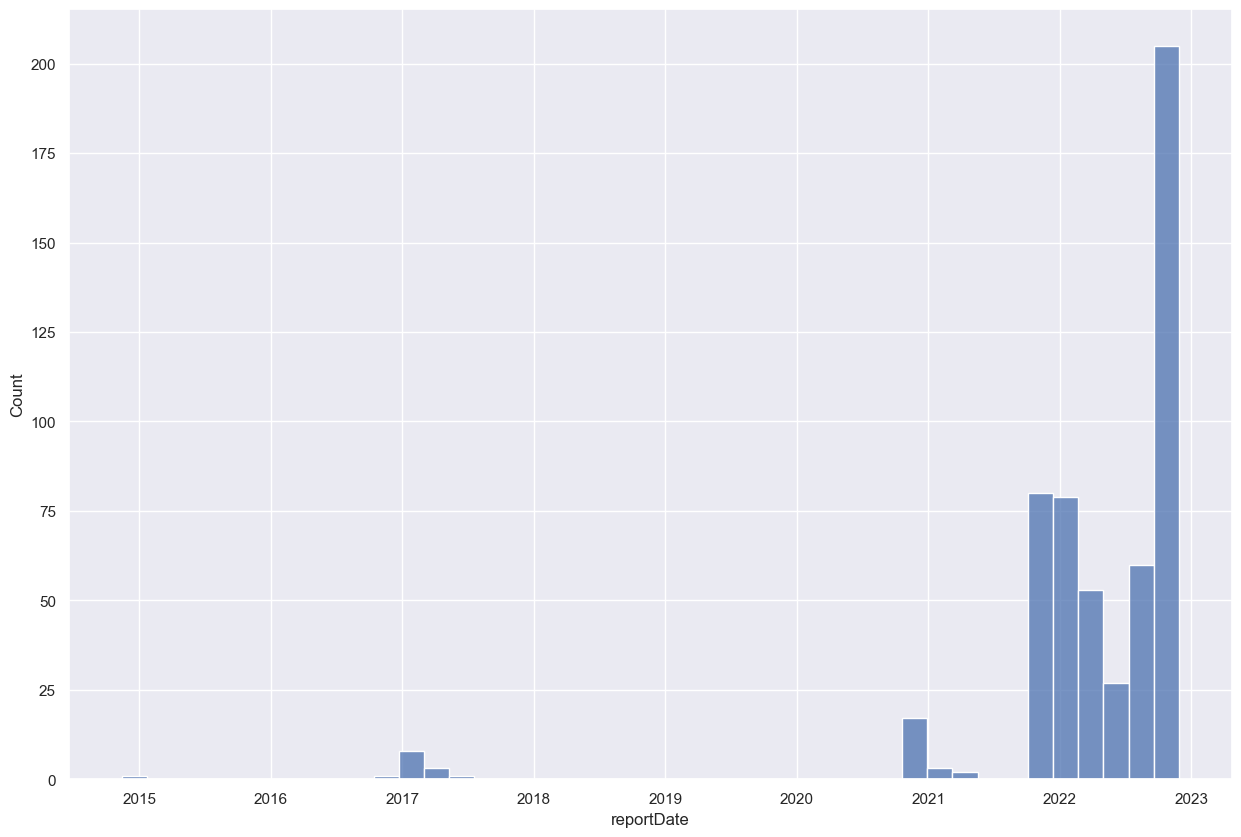

In [14]:
sns.histplot(data = hpai_main_dates, x = 'reportDate')

In [15]:
# most cases are in 2020 onwards so we filter out the 2017 wave 
hpai_main_dates = hpai_main_dates[hpai_main_dates.reportDate >= datetime.datetime(2020,1, 1, 0,0,0)]

In [16]:
# Time variables for hpai_wild:
# Date Received
# Test date
# Date PHE informed

hpai_wild[['Date Received', 'Test date', 'Date PHE informed']] = hpai_wild[['Date Received', 'Test date', 'Date PHE informed']].apply(
    lambda x: pd.to_datetime(x, infer_datetime_format=True), axis=1)

## Geopandas attempts

<AxesSubplot:xlabel='Long', ylabel='Lat'>

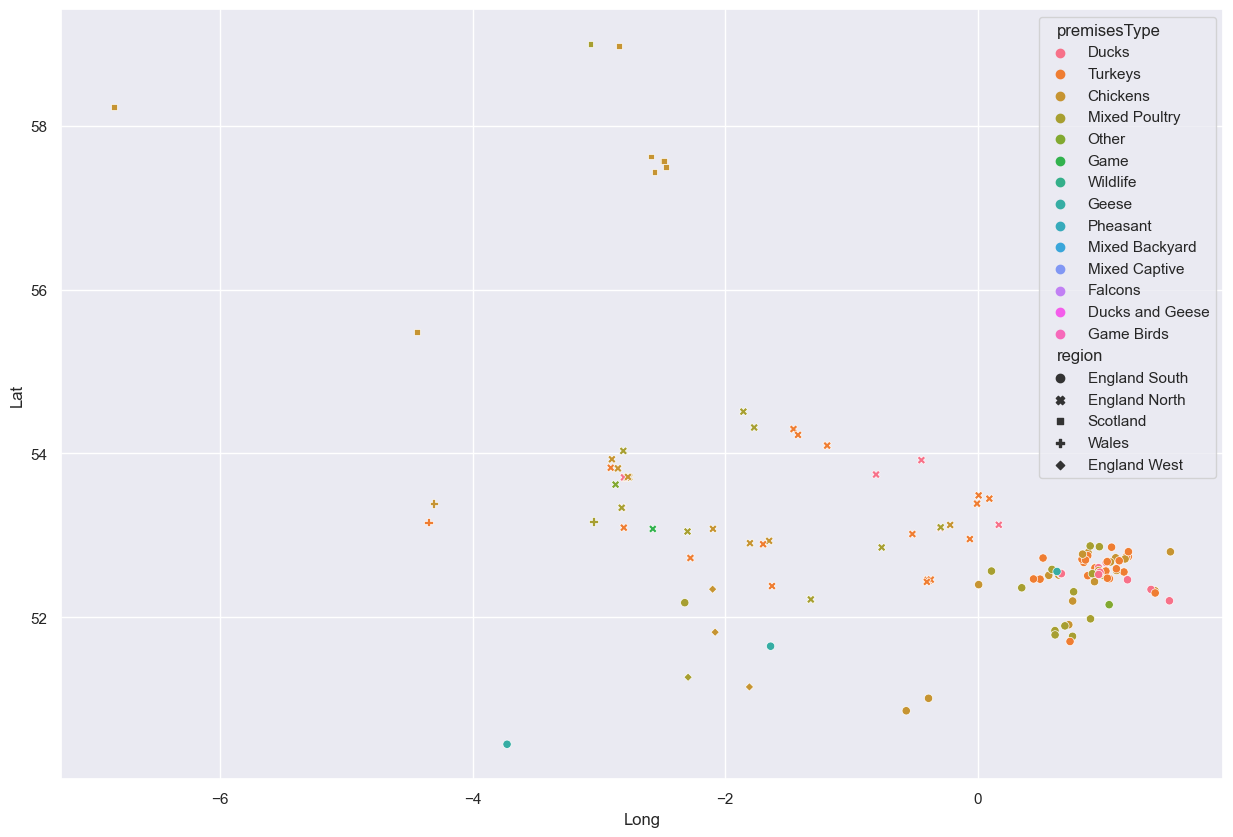

In [17]:
sns.scatterplot(data=hpai_main, x = 'Long', y = 'Lat', style = 'region', hue='premisesType')

<AxesSubplot:xlabel='easting', ylabel='northing'>

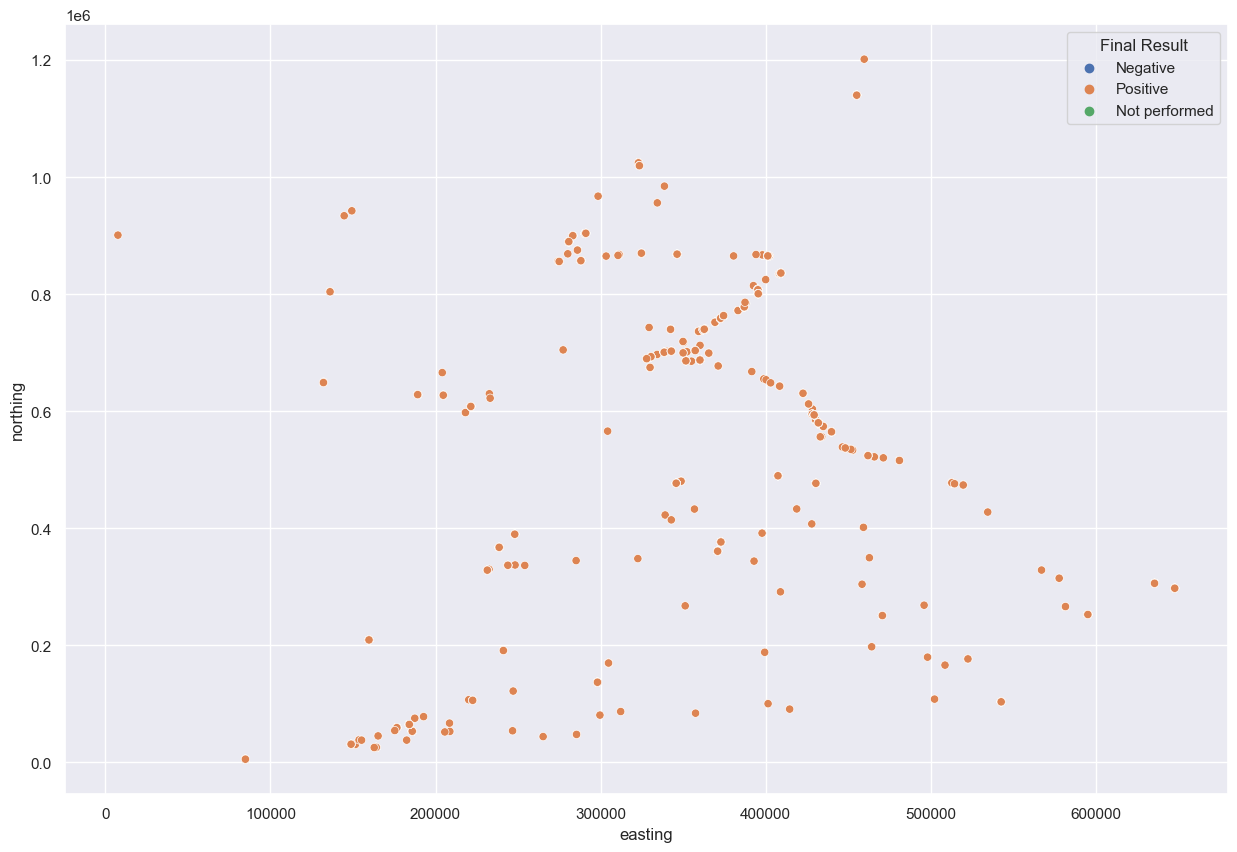

In [18]:
sns.scatterplot(data=hpai_wild, x = 'easting', y = 'northing', hue='Final Result')

In [19]:
geo_hpai_main = geopandas.GeoDataFrame(
    hpai_main, geometry=geopandas.points_from_xy(hpai_main.Long, hpai_main.Lat))

In [20]:
geo_hpai_wild = geopandas.GeoDataFrame(
    hpai_wild, geometry=geopandas.points_from_xy(hpai_wild.longitude, hpai_wild.latitude))

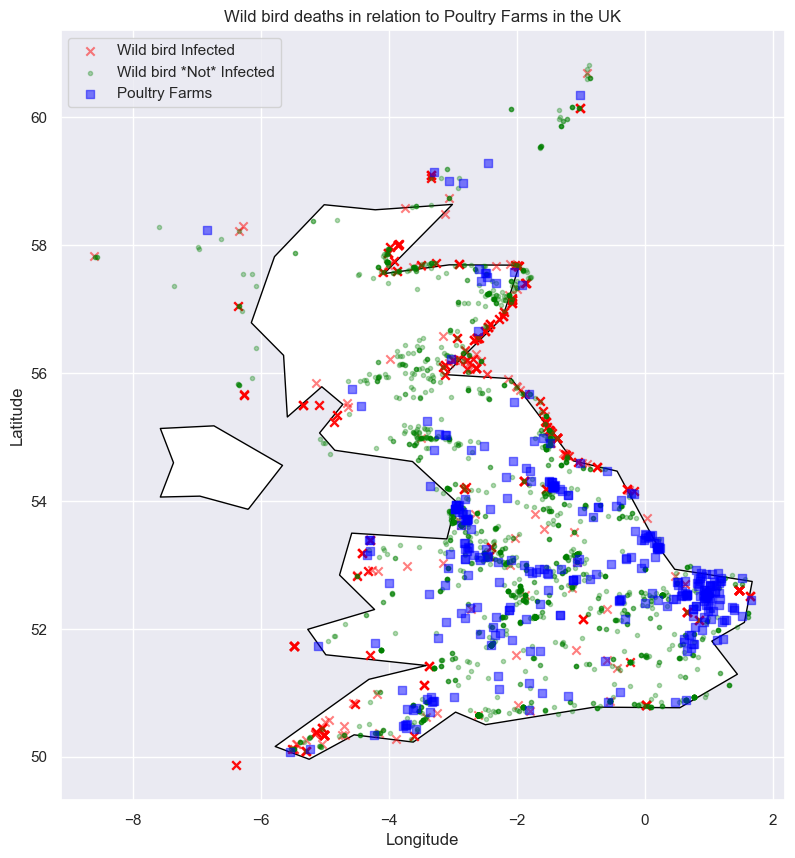

In [21]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


# restrict to UK.
ax = world[world.name == 'United Kingdom'].plot(
    color='white', edgecolor='black')

# plot our ``GeoDataFrame``.
geo_hpai_wild[geo_hpai_wild['Final Result'] == 'Positive'].plot(
    ax=ax, color='red', alpha=0.5, label='Wild bird Infected',  marker='x')
geo_hpai_wild[geo_hpai_wild['Final Result'] != 'Positive'].plot(
    ax=ax, color='green', alpha=0.3, label='Wild bird *Not* Infected',  marker='.')
geo_hpai_main.plot(ax=ax, color='blue', marker='s',
                   label='Poultry Farms', alpha=0.5)

plt.title('Wild bird deaths in relation to Poultry Farms in the UK')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc="upper left")
plt.show()

# Extracting modeling data 

Proposed model: SEINR 

In [22]:
# spatial data - farm level
hpai_poultry[['Location Id', 'Easting', 'Northing']].to_csv('data_files/farm_locations.csv')

In [23]:
# time data - case level (will not have every farm infected)
hpai_main_dates.to_csv('data_files/hpai_temporal_data.csv')

In [24]:
# farm characteristics - from the hpai_main dataset so they align with the hpai_main_dates
# characteristics available for every infected/case but not for every farm (i.e. occults)! Harder to simulate
hpai_main[['approxNumBirds', 'Season', 'speciesPresent', 'businessType', 'premisesType']]

# any derivative data sets from the main file can be matched by index, o/w need to match by location? 

,approxNumBirds,Season,speciesPresent,businessType,premisesType
0,80000,NaN,NaN,NaN,Ducks
1,3342,NaN,NaN,NaN,Turkeys
2,400,NaN,NaN,NaN,Chickens
3,32000,2022.0,Chickens,Commercial,Chickens
4,4,NaN,NaN,NaN,Chickens
...,...,...,...,...,...
535,NaN,2020.0,Game Birds,Commercial,Game Birds
536,NaN,2020.0,Chickens,Commercial,Chickens
537,NaN,2020.0,Game Birds,Commercial,Game Birds
538,NaN,2020.0,Chickens,Commercial,Chickens


In [25]:
hpai_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   dprNumber       504 non-null    object  
 1   aivNumber       324 non-null    object  
 2   reportDate      540 non-null    object  
 3   Status          504 non-null    object  
 4   NDI1Type        504 non-null    object  
 5   Resolution      495 non-null    object  
 6   Stock Details   499 non-null    object  
 7   CPH             369 non-null    object  
 8   Country         503 non-null    object  
 9   dprID           504 non-null    object  
 10  aivID           324 non-null    object  
 11  ipNumber        134 non-null    float64 
 12  region          191 non-null    object  
 13  approxNumBirds  190 non-null    object  
 14  Year            324 non-null    float64 
 15  Season          324 non-null    float64 
 16  Subtype         249 non-null    object  
 17  infDate         

# Simulation 

In [26]:
import sys 

sys.path.append('/Users/alinmorariu/Documents/Github/ContinuousTimeIndividualLevelEpidemicModels')

In [27]:
import ContinousTimeStateTransitionModel as epi_sim

2023-07-06 18:31:08.716842: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fake data 

In [28]:
# location data
num_farms = 1000
np.random.seed(1356315)
location_data = np.random.uniform(low = 0.0, high = 1000.0, size = (num_farms,2))
location_data = pd.DataFrame(location_data, columns= ('Long', 'Lat'))
location_data.head()

,Long,Lat
0,489.152364,99.924608
1,744.422926,164.224133
2,29.352368,350.934199
3,247.268800,952.144133
4,948.006707,304.171672


<AxesSubplot:xlabel='Long', ylabel='Lat'>

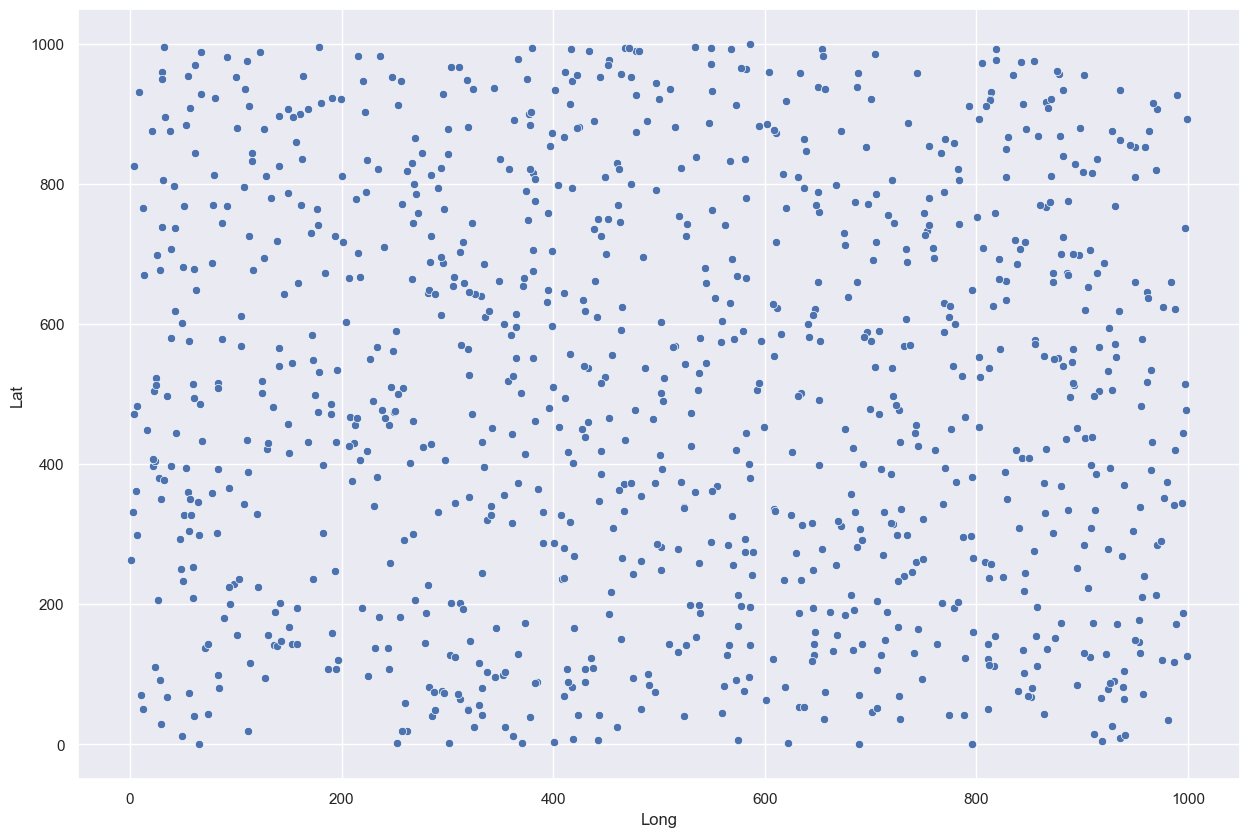

In [29]:
sns.scatterplot(data=location_data, x='Long', y='Lat')

In [30]:
# farm type data 
farm_types = ['chicken', 'other']
np.random.seed(1356315)


In [31]:
# Create hazard fn 
DTYPE = tf.float32
def pairwise_distance(farm_locations_data):
    """Compute pairwise distance matrix between farms

    Args:
        farm_locations_data (DataFrame): Lat-Long coordinates of farms

    Returns:
        tensor: tensor of Euclidean distances between entities
                Dim = len(farm_location_data)
    """
    return tf.convert_to_tensor(
        sp.spatial.distance.squareform(
            sp.spatial.distance.pdist(farm_locations_data)
        ),
        dtype=DTYPE
    )

In [32]:
# eg. spatial distance
pairwise_distance(farm_locations_data= location_data)

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[   0.     ,  263.24417,  523.8529 , ...,  919.12366,  263.98505,
         575.8765 ],
       [ 263.24417,    0.     ,  739.0444 , ..., 1008.3365 ,  287.13318,
         745.43414],
       [ 523.8529 ,  739.0444 ,    0.     , ...,  574.65814,  505.1158 ,
         166.37543],
       ...,
       [ 919.12366, 1008.3365 ,  574.65814, ...,    0.     ,  723.28735,
         414.94156],
       [ 263.98505,  287.13318,  505.1158 , ...,  723.28735,    0.     ,
         474.97015],
       [ 575.8765 ,  745.43414,  166.37543, ...,  414.94156,  474.97015,
           0.     ]], dtype=float32)>

In [33]:
# Datetimes for events 
np.random.seed(1356315)

infectious_period_range = np.arange(0, 20)
base_date = np.datetime64('2023-01-07')
infectious_dates = base_date + np.random.choice(infectious_period_range, num_farms)

infectious_dates

array(['2023-01-16', '2023-01-25', '2023-01-20', '2023-01-19',
       '2023-01-20', '2023-01-18', '2023-01-18', '2023-01-23',
       '2023-01-15', '2023-01-07', '2023-01-16', '2023-01-10',
       '2023-01-18', '2023-01-15', '2023-01-14', '2023-01-23',
       '2023-01-17', '2023-01-18', '2023-01-10', '2023-01-19',
       '2023-01-25', '2023-01-09', '2023-01-14', '2023-01-15',
       '2023-01-10', '2023-01-20', '2023-01-11', '2023-01-25',
       '2023-01-08', '2023-01-18', '2023-01-14', '2023-01-26',
       '2023-01-14', '2023-01-08', '2023-01-18', '2023-01-25',
       '2023-01-08', '2023-01-12', '2023-01-09', '2023-01-24',
       '2023-01-24', '2023-01-19', '2023-01-12', '2023-01-22',
       '2023-01-25', '2023-01-22', '2023-01-15', '2023-01-15',
       '2023-01-09', '2023-01-20', '2023-01-20', '2023-01-18',
       '2023-01-09', '2023-01-26', '2023-01-24', '2023-01-11',
       '2023-01-08', '2023-01-14', '2023-01-23', '2023-01-24',
       '2023-01-17', '2023-01-19', '2023-01-12', '2023-

In [34]:
removal_dates = infectious_dates + 4

In [35]:
key_dates = pd.DataFrame({'inf_date': pd.to_numeric(infectious_dates), 
                          'removal_date': pd.to_numeric(removal_dates)})
key_dates

,inf_date,removal_date
0,19373,19377
1,19382,19386
2,19377,19381
3,19376,19380
4,19377,19381
...,...,...
995,19365,19369
996,19371,19375
997,19373,19377
998,19371,19375


In [36]:
key_dates.iloc[:,0]

0      19373
1      19382
2      19377
3      19376
4      19377
       ...  
995    19365
996    19371
997    19373
998    19371
999    19377
Name: inf_date, Length: 1000, dtype: int64

In [37]:
def generate_waifw(infection_times, removal_times):
    """
    Compute a WAIFW (who acquired infection from who) matrix 
    given tensors of infection and removal times. 

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of 1s and 0s
    """

    infection_times = tf.convert_to_tensor(infection_times)
    removal_times = tf.convert_to_tensor(removal_times)

    # use the expand_dim to do the [I,:] trick
    waifw = tf.math.logical_and(
        # compare infections to infections: I_i <= I_j
        infection_times[tf.newaxis, :] < infection_times[:, tf.newaxis],
        # compare infections to removals: I_j <= R_i
        infection_times[:, tf.newaxis] < removal_times[tf.newaxis, :]
    )
    return tf.cast(waifw,
                   dtype=DTYPE)

In [38]:
generate_waifw(infection_times= key_dates.iloc[:,0],
              removal_times= key_dates.iloc[:,1])

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [39]:
def generate_exposure(infection_times, removal_times):
    """
    Compute exposure matrix given two tensors of infections and removal times

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of exposure
        durations 
    """

    return (
        tf.math.minimum(infection_times[:, tf.newaxis],
                        removal_times[tf.newaxis, :]) -
        tf.math.minimum(infection_times[:, tf.newaxis],
                        infection_times[tf.newaxis, :])
    )

In [40]:
generate_exposure(infection_times= key_dates.iloc[:,0],
              removal_times= key_dates.iloc[:,1])

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_2324/2203921878.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tf.math.minimum(infection_times[:, tf.newaxis],
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_2324/2203921878.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  removal_times[tf.newaxis, :]) -
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_2324/2203921878.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  tf.math.minimum(infection_times[:, tf.newaxis],
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_2324/2203921878

<tf.Tensor: shape=(1000, 1000), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 2, 0],
       [4, 0, 4, ..., 4, 4, 4],
       [4, 0, 0, ..., 4, 4, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 4, 4, 0]])>

In [41]:
def generate_spatial_kernel(farm_distance_matrix):
    """Compute the square exponential spatial kernel given a pairwise distance matrix

    Args:
        farm_distance_matrix (tensor): matrix of pairwise distance

    Returns:
        function: function taking in spatial pressure parameter based on 
    """
    farm_distance_matrix = tf.convert_to_tensor(farm_distance_matrix, DTYPE)
    def square_exponential_kernel(parameters):
        partial_step = tf.math.multiply(farm_distance_matrix, 1/parameters)
        return tf.math.exp(tf.math.negative(tf.math.square(partial_step)))
    return square_exponential_kernel

In [42]:
farm_distances = pairwise_distance(farm_locations_data= location_data)
spatial_kernel = generate_spatial_kernel(farm_distance_matrix= farm_distances)

spatial_kernel(500.0)

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[1.        , 0.7579105 , 0.3336417 , ..., 0.03407629, 0.7567272 ,
        0.26539522],
       [0.7579105 , 1.        , 0.11250623, ..., 0.01712921, 0.71908057,
        0.10831751],
       [0.3336417 , 0.11250623, 1.        , ..., 0.26688752, 0.36039013,
        0.89518654],
       ...,
       [0.03407629, 0.01712921, 0.26688752, ..., 1.        , 0.1233686 ,
        0.5022255 ],
       [0.7567272 , 0.71908057, 0.36039013, ..., 0.1233686 , 1.        ,
        0.4056005 ],
       [0.26539522, 0.10831751, 0.89518654, ..., 0.5022255 , 0.4056005 ,
        1.        ]], dtype=float32)>

In [43]:
# farm type data 
np.random.seed(1356315)
farm_types = np.random.choice((0,1), size = num_farms) # chicken, o/w 

In [44]:
def generate_regression_pressure(farm_characteristics_data = None): 
    """_summary_

    Args:
        farm_characteristics_data (_type_, optional): Factor variables for each farm unit. Defaults to None.

    Returns:
        tensor: exp(alpha + beta^T * data)
    """
    farm_characteristics_data = tf.convert_to_tensor(farm_characteristics_data, DTYPE)
    def compute_regression(parameters):
        # regression does not include the intercept term 
        regression = tf.math.multiply(farm_characteristics_data, parameters)
        expontiated_regression = tf.math.exp(regression)
        return expontiated_regression
        
    return compute_regression

In [45]:
regression_pressure = generate_regression_pressure(farm_characteristics_data=farm_types)
regression_pressure(parameters=0.7)

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([1.       , 2.0137527, 1.       , 1.       , 2.0137527, 1.       ,
       1.       , 2.0137527, 2.0137527, 1.       , 2.0137527, 1.       ,
       1.       , 1.       , 2.0137527, 1.       , 2.0137527, 2.0137527,
       2.0137527, 2.0137527, 1.       , 1.       , 1.       , 1.       ,
       2.0137527, 1.       , 1.       , 2.0137527, 1.       , 1.       ,
       2.0137527, 1.       , 1.       , 1.       , 1.       , 1.       ,
       2.0137527, 2.0137527, 1.       , 2.0137527, 2.0137527, 1.       ,
       1.       , 2.0137527, 2.0137527, 2.0137527, 1.       , 2.0137527,
       2.0137527, 1.       , 1.       , 2.0137527, 1.       , 1.       ,
       2.0137527, 2.0137527, 1.       , 1.       , 2.0137527, 1.       ,
       2.0137527, 2.0137527, 1.       , 2.0137527, 2.0137527, 1.       ,
       2.0137527, 2.0137527, 1.       , 2.0137527, 2.0137527, 1.       ,
       2.0137527, 1.       , 1.       , 1.       , 1.       , 1.       ,
  

In [46]:
def generate_pairwise_hazard_fn(farm_distance_matrix, farm_characteristics_data=None):
    """_summary_

    Args:
        farm_characteristics_data (_type_): features of farms, including a 1s column for regression
        farm_locations_data (_type_): Northing-Easting coordinates of farms

    Returns:
        fn: fn which outputs a tensor of pairwise hazard rates 
    """
    spatial_kernel = generate_spatial_kernel(farm_distance_matrix)
    regression_kernel = generate_regression_pressure(farm_characteristics_data)
    
    def compute_hazard(parameters):
        # regression component - have a column of 1s in the data
        # Fill in later

        # spatial component - already exponentiated!
        spatial = spatial_kernel(parameters[0])
        
        # regression component - already exponentiated!
        regression = regression_kernel(parameters[1])
        return tf.math.multiply(spatial,
                                regression
                               )

    return compute_hazard

In [47]:
hazard_fn = generate_pairwise_hazard_fn(farm_distance_matrix=farm_distances, farm_characteristics_data=farm_types)
tf.einsum('ij -> i', hazard_fn([500.0,0.7]))

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([619.43756, 613.2016 , 502.18634, 478.77274, 526.73395, 663.11914,
       522.4959 , 817.32495, 646.8234 , 491.78342, 761.1731 , 707.46094,
       774.32184, 621.0154 , 774.30493, 329.7955 , 837.58307, 473.50876,
       776.94745, 789.1935 , 341.71582, 473.94012, 798.83765, 564.94824,
       779.30963, 677.85956, 659.8422 , 618.61707, 693.1407 , 453.7754 ,
       586.5132 , 410.6225 , 377.8674 , 782.9976 , 751.70355, 540.4596 ,
       720.36566, 535.42377, 767.8511 , 511.41415, 626.11786, 656.5018 ,
       645.7009 , 624.41077, 641.1967 , 636.3826 , 391.46964, 754.0965 ,
       621.36444, 813.47406, 635.9486 , 516.97754, 682.03516, 828.2966 ,
       603.5759 , 410.64206, 380.418  , 675.2836 , 616.8308 , 728.78436,
       667.17706, 792.7581 , 541.2004 , 490.4084 , 496.26776, 766.2086 ,
       691.0686 , 789.134  , 752.2634 , 626.7334 , 732.9148 , 490.297  ,
       523.8918 , 819.8834 , 830.3071 , 649.02014, 624.49335, 369.9115 ,
  

In [48]:
# make rate fn for simulation 
def make_rate_fn(parameters):
    # keep data variables and parameters on the outside
    def rate_fn(t, state):
        # t and state change with each iteration of the Gillespie so they are
        # a loop variable and thus inside the rate_fn
        si_rate = tf.einsum('ij -> i', hazard_fn(parameters))
        ir_rate = tf.broadcast_to([70.0], shape=si_rate.shape)
        return tf.stack([si_rate, ir_rate], axis=0)  # [R x M]
    return rate_fn

In [49]:
make_rate_fn([500.0, 0.07])(1,np.array([[9],
                          [1],
                          [0]], dtype=np.float32) )

<tf.Tensor: shape=(2, 1000), dtype=float32, numpy=
array([[417.18063, 415.5016 , 341.01025, ..., 278.43665, 555.557  ,
        398.46707],
       [ 70.     ,  70.     ,  70.     , ...,  70.     ,  70.     ,
         70.     ]], dtype=float32)>

In [50]:
# Define variables to govern epidemic
sir_graph = np.array([[-1, 0],
                      [1, -1],
                      [0, 1]], dtype=np.float32)


initial_state = np.array([[900],
                          [100],
                          [0]], dtype=np.float32)

In [51]:
example_epidemic = epi_sim.ContinuousTimeStateTransitionModelSimulation(
    incidence_matrix=sir_graph,
    initial_state=initial_state,
    transition_rate_fn=make_rate_fn([500,0.07])
)

In [52]:
# simulate the epidemic
epidemic1 = example_epidemic.simulate_continuous_time_state_transition_model()
time_stamps, transition_types, individual = example_epidemic.simulate_continuous_time_state_transition_model()

In [53]:
time_stamps, transition_types, individual

(<tf.Tensor: shape=(1900,), dtype=float32, numpy=
 array([8.450908e-08, 9.623609e-07, 2.227527e-06, ..., 7.496857e-02,
        8.624509e-02, 8.776300e-02], dtype=float32)>,
 <tf.Tensor: shape=(1900,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1], dtype=int32)>,
 <tf.Tensor: shape=(1900,), dtype=int32, numpy=array([824, 345, 528, ..., 777, 941,  19], dtype=int32)>)

In [54]:
long_form_epi1 = epi_sim._compute_state(initial_state= epi_sim._expand_state(initial_state),
                      event_list= epidemic1,
                      incidence_matrix=sir_graph)

In [55]:
long_form_epi1

(<tf.Tensor: shape=(1901,), dtype=float32, numpy=
 array([0.0000000e+00, 1.2049096e-06, 3.8831395e-06, ..., 1.7959175e+01,
        1.8044518e+01, 1.8141628e+01], dtype=float32)>,
 <tf.Tensor: shape=(1901, 3, 1000), dtype=float32, numpy=
 array([[[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [1., 1., 1., ..., 1., 1., 1.]]], dtype=float

In [56]:
summary = tf.concat([tf.expand_dims(long_form_epi1[0], axis=1, name='time'),
                         tf.reduce_sum(long_form_epi1[1], axis=-1)],
                        axis=-1,
                        name="full_epidemic")
format_summary = pd.DataFrame(summary.numpy())

new_names = dict(zip(format_summary.columns,
                         ['time'] + ['S', 'I', 'R'])
                     )

format_summary = format_summary.rename(columns=new_names)

Text(0.5, 1.0, 'Simulated Epidemic')

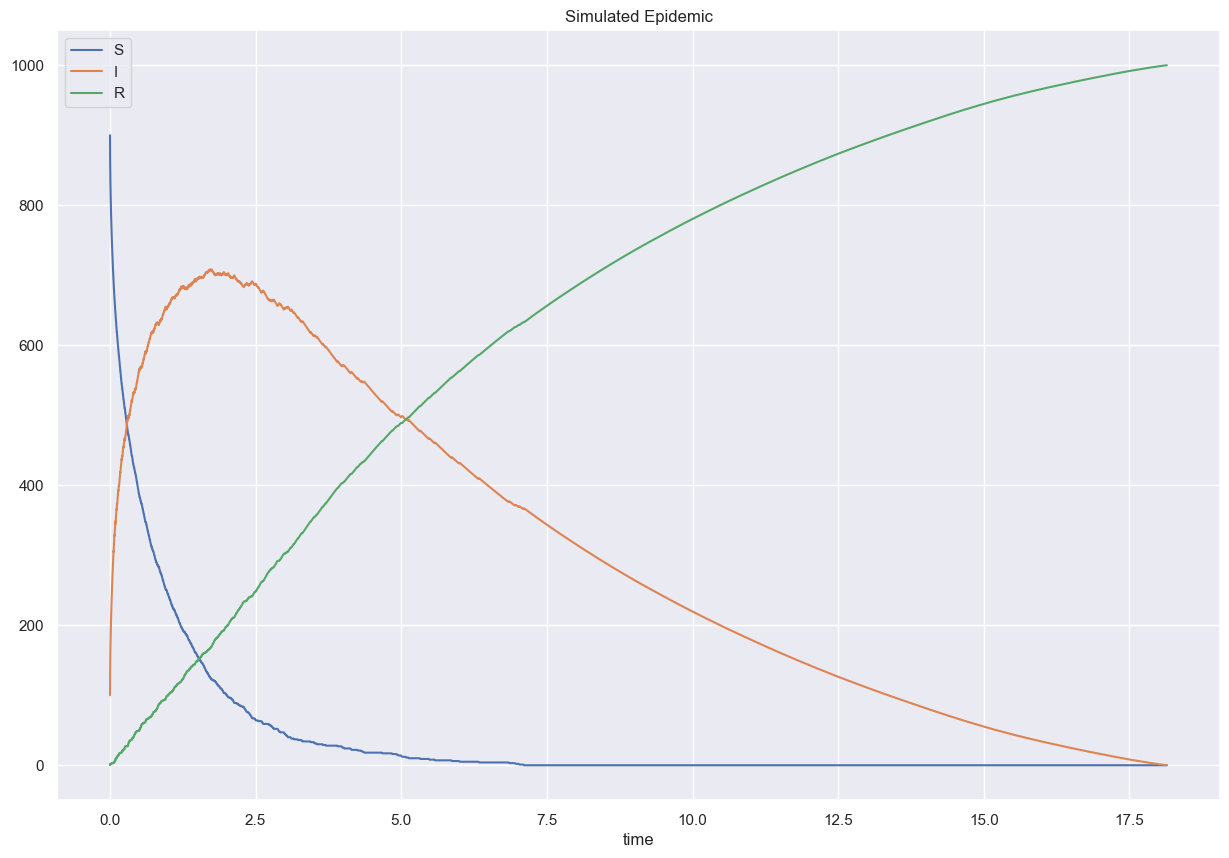

In [57]:
format_summary.iloc[:, ].plot(x='time')
plt.title('Simulated Epidemic')

# Inference 
## Centred MCMC 

In [58]:
@tf.function(jit_compile=True)
def centred_MCMC(target_log_prob_fn, initial_parameter_values, iter=25):
    '''
    MCMC sampler for centred parameterization of a 
    partially observed epidemic. Data generated from 
    SIR model. 
    '''

    dtype = np.float32
    initial_parameter_values = tf.convert_to_tensor(initial_parameter_values,
                                                    dtype=dtype)

    # generate initial values for missing data
    infection_times = removal_times - 5.0

    def single_iteration(parameters, infection_times):
        '''
        Define a single iteration of the sampler. We first update the parameters,
        followed by updating an infection time. 
        '''

        # 1(a) Propose new parameter values from Q(.)
        new_param = tfd.Normal(loc=parameters,
                               scale=[0.02, 0.01, 0.001, 0.01]).sample()

        # 1(b) Accept/reject
        a1 = target_log_prob_fn(new_param, infection_times) - \
            target_log_prob_fn(parameters, infection_times)

        # 1(c) Check
        def parameter_true_fn():
            return new_param, 1

        def parameter_false_fn():
            return parameters, 0

        is_param_accept = tf.math.log(tfd.Uniform().sample()) < a1

        parameters, result_param = tf.cond(is_param_accept,
                                           parameter_true_fn,
                                           parameter_false_fn)

        # 2(a) Propose new infection time from Q_i(.)
        # Part i - choose a person
        individual_ID = tfd.Categorical(
            logits=tf.zeros_like(removal_times)).sample()
        # Part ii - propose new infection time
        proposal = tfd.Exponential(rate=1.5)
        new_infectious_period = proposal.sample()

        current_infectious_periods = removal_times - infection_times
        new_infectious_periods = tf.tensor_scatter_nd_update(
            tensor=current_infectious_periods,
            indices=[[individual_ID]],
            updates=[new_infectious_period]
        )
        new_infection_times = removal_times - new_infectious_periods

        # 2(b) Accept/reject
        a2 = (
            target_log_prob_fn(parameters, new_infection_times)
            - target_log_prob_fn(parameters, infection_times)
            + proposal.log_prob(
                tf.gather(current_infectious_periods, individual_ID)
            )
            - proposal.log_prob(new_infectious_period)
        )

        # 2(c) Check
        def infection_true_fn():
            return new_infection_times, 1

        def infection_false_fn():
            return infection_times, 0

        is_infection_accept = tf.math.log(tfd.Uniform().sample()) < a2

        infection_times, result_inf = tf.cond(is_infection_accept,
                                              infection_true_fn,
                                              infection_false_fn)

        return x

    # Construct while loop here
    parameter_samples = tf.TensorArray(
        initial_parameter_values.dtype, size=iter)
    infection_times_samples = tf.TensorArray(infection_times.dtype, size=iter)
    results = tf.TensorArray(infection_times.dtype, size=iter)

    def cond(i,
             current_parameters,
             current_infection_times,
             parameter_accum,
             infection_times_accum,
             results_accum):
        return i < iter

    def body(i,
             current_parameters,
             current_infection_times,
             parameter_accum,
             infection_times_accum,
             results_accum):

        (next_parameters,
         next_infection_times,
         results) = single_iteration(parameters=current_parameters,
                                     infection_times=current_infection_times)

        parameter_accum = parameter_accum.write(i, next_parameters)
        infection_times_accum = infection_times_accum.write(
            i, next_infection_times)
        results_accum = results_accum.write(i, results)

        return (i+1,
                next_parameters,
                next_infection_times,
                parameter_accum,
                infection_times_accum,
                results_accum)

    (
        _1,
        _2,
        _3,
        parameter_samples,
        infection_times_samples,
        results) = tf.while_loop(cond=cond,
                                 body=body,
                                 loop_vars=(0,
                                            initial_parameter_values,
                                            infection_times,
                                            parameter_samples,
                                            infection_times_samples,
                                            results)
                                 )
    return parameter_samples.stack(), infection_times_samples.stack(), results.stack()

## Target log prob 

In [59]:
formatted_data = pd.DataFrame({'time_stamp':time_stamps, 'event_type':transition_types, 'ind_id':individual})

In [60]:
formatted_data.sort_values('ind_id')

,time_stamp,event_type,ind_id
84,0.000192,0,0
1423,0.012584,1,0
1840,0.040039,1,1
341,0.001058,0,1
946,0.004698,0,2
...,...,...,...
1893,0.068254,1,995
648,0.002539,1,996
1441,0.012875,1,997
1072,0.006206,1,998


In [61]:
event_time_data = formatted_data.melt(id_vars=['ind_id', 'event_type'],
                                      value_vars=['time_stamp'],
                                      value_name='time_stamp').sort_values('ind_id').pivot(index='ind_id',
                                                                                           columns='event_type',
                                                                                           values='time_stamp').fillna(0.0)

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_2324/1499167911.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  event_time_data = formatted_data.melt(id_vars=['ind_id', 'event_type'],


In [62]:
event_time_data

event_type,0,1
ind_id,,
0,0.000192,0.012584
1,0.001058,0.040039
2,0.004698,0.007077
3,0.000718,0.038892
4,0.002699,0.019722
...,...,...
995,0.000000,0.068254
996,0.000000,0.002539
997,0.000000,0.012875


In [63]:
np.column_stack((time_stamps, individual,transition_types))

array([[8.45090824e-08, 8.24000000e+02, 0.00000000e+00],
       [9.62360900e-07, 3.45000000e+02, 0.00000000e+00],
       [2.22752692e-06, 5.28000000e+02, 0.00000000e+00],
       ...,
       [7.49685690e-02, 7.77000000e+02, 1.00000000e+00],
       [8.62450898e-02, 9.41000000e+02, 1.00000000e+00],
       [8.77629966e-02, 1.90000000e+01, 1.00000000e+00]])

In [64]:
tf.gather(individual, np.argwhere(transition_types == 1).ravel())

<tf.Tensor: shape=(1000,), dtype=int32, numpy=
array([942, 962, 967, 925, 910, 813, 114, 568, 298, 987, 786, 805, 433,
       126,  84, 792, 927, 455, 917, 101, 838, 680, 181, 185, 481, 370,
       794,  44, 209, 887,  79, 454, 744, 413,  33, 863,  97,  81, 770,
       678,  18,  89, 268, 642, 782, 524, 701, 935, 504, 775, 827, 303,
       946, 906, 904,  41,   7,  62, 589, 653, 229, 512, 364, 377, 106,
       306, 989, 833, 643, 259, 919, 996, 447, 546, 791, 874, 324, 936,
       758, 211, 158,  50, 508, 873, 953, 489, 784,  57, 639,  29, 249,
       945, 550, 980, 956, 212, 727, 201, 881, 831, 383, 427, 421, 834,
       556, 867, 169, 969, 787, 865, 152, 565, 591, 554, 993, 246, 283,
       341, 418, 264, 396, 850, 667, 244,  23, 171, 221, 446, 366, 286,
       374, 271, 426, 289, 598, 354, 886, 123, 584, 981,  17, 724, 810,
       316, 937, 793, 703, 679, 503, 182, 510, 336,  34, 272, 415, 320,
       302, 345, 745, 190, 983, 752, 195, 817, 799, 988, 644, 243, 911,
       738, 192, 

In [65]:
simulated_removal_times = tf.gather(
    time_stamps, np.argwhere(transition_types == 1).ravel())

In [66]:
simulated_infection_times = tf.pad(tf.gather(time_stamps, np.argwhere(transition_types == 0).ravel()),
                                   paddings=tf.constant([[0, 100]]))

In [67]:
generate_waifw(infection_times=simulated_infection_times,
               removal_times=simulated_removal_times)

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [68]:
generate_exposure(infection_times=simulated_infection_times,
                  removal_times=simulated_removal_times)

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 8.4509082e-08,
        8.4509082e-08, 8.4509082e-08],
       [8.7785179e-07, 0.0000000e+00, 0.0000000e+00, ..., 9.6236090e-07,
        9.6236090e-07, 9.6236090e-07],
       [2.1430178e-06, 1.2651660e-06, 0.0000000e+00, ..., 2.2275269e-06,
        2.2275269e-06, 2.2275269e-06],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [69]:
simualted_exposure_mat = tf.matmul(a=generate_waifw(infection_times=simulated_infection_times, removal_times=simulated_removal_times),
          b=generate_exposure(infection_times=simulated_infection_times, removal_times=simulated_removal_times))

In [70]:
def drop_initial_infections(infection_times):
    return np.argwhere(infection_times != 0.0).ravel()

In [71]:
drop_initial_infections(infection_times=simulated_infection_times)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [72]:
tf.einsum('ij -> i', tf.gather(simualted_exposure_mat,
          indices=drop_initial_infections(infection_times=simulated_infection_times)))

<tf.Tensor: shape=(900,), dtype=float32, numpy=
array([0.00000000e+00, 8.45090290e-06, 1.05564897e-04, 3.31725518e-04,
       1.02613692e-03, 1.78071798e-03, 2.60807062e-03, 3.65513074e-03,
       4.77067195e-03, 6.25092164e-03, 8.13527312e-03, 1.03339311e-02,
       1.30468346e-02, 1.63211543e-02, 1.96121018e-02, 2.29467303e-02,
       2.64140721e-02, 3.00135929e-02, 3.37321684e-02, 3.75114232e-02,
       4.13231105e-02, 4.53036241e-02, 4.99049053e-02, 5.50027117e-02,
       6.02939986e-02, 6.56982511e-02, 7.11691007e-02, 7.69517645e-02,
       8.29022080e-02, 8.94108266e-02, 9.69043598e-02, 1.05271369e-01,
       1.13644600e-01, 1.22767463e-01, 1.32882759e-01, 1.43031090e-01,
       1.53562173e-01, 1.64284617e-01, 1.75176322e-01, 1.86192319e-01,
       1.97685599e-01, 2.09713563e-01, 2.21843094e-01, 2.34219000e-01,
       2.46863544e-01, 2.60109127e-01, 2.73448199e-01, 2.86827296e-01,
       3.00283194e-01, 3.13763589e-01, 3.27249587e-01, 3.41042131e-01,
       3.55348736e-01, 3.6967